<a href="https://colab.research.google.com/github/tommy-hartanto/rakamin/blob/main/Stage_3_Source_Code_Fantastic_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option("max_column",100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def eval_classification(model, X_train, y_train, X_test, y_test, threshold=0.5, flag=True, roc=True ):
    score=[] 
    
    pred_train = (model.predict_proba(X_train)[:,1]>threshold)
    pred_test = (model.predict_proba(X_test)[:,1]>threshold)

    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,y_train)
    test_acc = accuracy_score(pred_test,y_test)
    
    train_recall = recall_score(y_train,pred_train)
    test_recall = recall_score(y_test,pred_test)
    
    train_precision = precision_score(y_train,pred_train)
    test_precision = precision_score(y_test,pred_test)
    
    train_f1 = f1_score(y_train,pred_train)
    test_f1 = f1_score(y_test,pred_test)
    
    
    score.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1,pred_train,pred_test))
        
    
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,y_train))
        print("Accuracy on test set : ",accuracy_score(pred_test,y_test))
        print("Recall on training set : ",recall_score(y_train,pred_train))
        print("Recall on test set : ",recall_score(y_test,pred_test))
        print("Precision on training set : ",precision_score(y_train,pred_train))
        print("Precision on test set : ",precision_score(y_test,pred_test))
        print("F1 on training set : ",f1_score(y_train,pred_train))
        print("F1 on test set : ",f1_score(y_test,pred_test))
   
    if roc == True:
        pred_train_prob = model.predict_proba(X_train)[:,1]
        pred_test_prob = model.predict_proba(X_test)[:,1]
        print("ROC-AUC Score on training set : ",roc_auc_score(y_train,pred_train))
        print("ROC-AUC Score on test set : ",roc_auc_score(y_test,pred_test))
        print("PR-AUC Score on training set : ",average_precision_score(y_train,pred_train))
        print("PR-AUC Score on test set : ",average_precision_score(y_test,pred_test))
    
    return score # returning the list with train and test scores

In [3]:
## Fungsi untuk mengeluarkan confusion matrix
def confusion_matrix(model,test_X,y_actual,i,seg,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    test_X: test set
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_X)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[1,0])
    df_cm = pd.DataFrame(cm, index = [i for i in ['Actual - Subscribed', 'Actual - Not Subscribed']],
                  columns = [i for i in ['Predicted - Subscribed','Predicted - Not Subscribed']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='', ax=axes[i], cmap='Blues').set(title='Confusion Matrix of {} Set'.format(seg))

In [19]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

# 1. Split Data Train & Test

In [5]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Preprocessing Train2.csv')
df.head(1)

,education,default,housing,loan,y,balance_norm,age_std,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown
0,3,0,1,0,0,0.758809,1.770427,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [6]:
# Split Feature and Label
X = df.drop(columns=['y'])
y = df['y'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [32]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(1, random_state = 42)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
y_train = pd.Series(y_train_oversampled)

In [33]:
print('Shape of Training set : ',X_train.shape )
print('\n')
print('Shape of test set : ',X_test.shape )
print('\n')
print('Percentage of classes in training set:\n',y_train.value_counts(normalize=True)*100)
print('\n')
print('Percentage of classes in test set:\n',y_test.value_counts(normalize=True)*100)

Shape of Training set :  (50084, 24)


Shape of test set :  (12037, 24)


Percentage of classes in training set:
 0    50.0
1    50.0
Name: y, dtype: float64


Percentage of classes in test set:
 0    88.851043
1    11.148957
Name: y, dtype: float64


# 2. Modeling

## Logistic Regression

### Model Fitting

In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [35]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [36]:
model.predict_proba(X_test)

array([[0.52511399, 0.47488601],
       [0.80660488, 0.19339512],
       [0.74823799, 0.25176201],
       ...,
       [0.44994796, 0.55005204],
       [0.60557159, 0.39442841],
       [0.59858308, 0.40141692]])

In [37]:
y_pred_train = model.predict(X_train)
y_pred_train

array([1, 0, 0, ..., 1, 1, 1])

### Model Evaluation

In [38]:
# Model Evaluation
y_pred = model.predict(X_test)
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.6762838431435189
Accuracy on test set :  0.6477527623161917
Recall on training set :  0.7074914144237681
Recall on test set :  0.665424739195231
Precision on training set :  0.6659274572448788
Precision on test set :  0.19064901793339026
F1 on training set :  0.6860805080643599
F1 on test set :  0.29638234317955525
ROC-AUC Score on training set :  0.6762838431435189
ROC-AUC Score on test set :  0.655480018031463
PR-AUC Score on training set :  0.6173922514179186
PR-AUC Score on test set :  0.16416422627200924


[0.6762838431435189,
 0.6477527623161917,
 0.7074914144237681,
 0.665424739195231,
 0.6659274572448788,
 0.19064901793339026,
 0.6860805080643599,
 0.29638234317955525,
 array([1., 0., 0., ..., 1., 1., 1.], dtype=float16),
 array([0., 0., 0., ..., 1., 0., 0.], dtype=float16)]

### Hyperparameter Tuning

In [39]:
scorer = metrics.make_scorer(metrics.recall_score)

In [40]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

logres = LogisticRegression(random_state=42, class_weight= 'balanced')
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fitting Model & Evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.6509863429438544
Accuracy on test set :  0.6082911024341613
Recall on training set :  0.7094880600591007
Recall on test set :  0.698956780923994
Precision on training set :  0.6351708851708852
Precision on test set :  0.1787007048961707
F1 on training set :  0.6702757762100577
F1 on test set :  0.2846305568199059
ROC-AUC Score on training set :  0.6509863429438544
ROC-AUC Score on test set :  0.6479356134633996
PR-AUC Score on training set :  0.5959021290963628
PR-AUC Score on test set :  0.1584672496374767


[0.6509863429438544,
 0.6082911024341613,
 0.7094880600591007,
 0.698956780923994,
 0.6351708851708852,
 0.1787007048961707,
 0.6702757762100577,
 0.2846305568199059,
 array([1., 0., 0., ..., 1., 1., 1.], dtype=float16),
 array([1., 0., 0., ..., 0., 0., 1.], dtype=float16)]

## K-Nearest Neighbors

### Model Fitting

In [41]:
#Fit Model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

### Model Evaluation

In [42]:
# Model Evaluation
y_pred = model.predict(X_test)
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.8680217235045125
Accuracy on test set :  0.7120544986292265
Recall on training set :  0.9129462502994968
Recall on test set :  0.46795827123695977
Precision on training set :  0.837681371830573
Precision on test set :  0.18579881656804734
F1 on training set :  0.8736958764856498
F1 on test set :  0.265988987717069
ROC-AUC Score on training set :  0.8680217235045125
ROC-AUC Score on test set :  0.6053208840990784
PR-AUC Score on training set :  0.8082849422087117
PR-AUC Score on test set :  0.14626319859015055


[0.8680217235045125,
 0.7120544986292265,
 0.9129462502994968,
 0.46795827123695977,
 0.837681371830573,
 0.18579881656804734,
 0.8736958764856498,
 0.265988987717069,
 array([0., 0., 0., ..., 1., 1., 0.], dtype=float16),
 array([1., 0., 0., ..., 0., 0., 0.], dtype=float16)]

### Hyperparameter Tuning

In [43]:
# List of hyperparameter
n_neighbors = list(range(222,224))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights=['uniform', 'distance']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

# Init model
knn = KNeighborsClassifier()
model_tuning = RandomizedSearchCV(knn, hyperparameters, cv=5, random_state=42, scoring='recall')
model_tuning.fit(X_train, y_train)

eval_classification(model_tuning, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.6707531347336475
Accuracy on test set :  0.6161003572318684
Recall on training set :  0.7341666001118121
Recall on test set :  0.6736214605067065
Precision on training set :  0.6515344815366079
Precision on test set :  0.17770788283860822
F1 on training set :  0.6903867818250093
F1 on test set :  0.2812256960647068
ROC-AUC Score on training set :  0.6707531347336474
ROC-AUC Score on test set :  0.6412520579765884
PR-AUC Score on training set :  0.6112515551094375
PR-AUC Score on test set :  0.15609564785146493


[0.6707531347336475,
 0.6161003572318684,
 0.7341666001118121,
 0.6736214605067065,
 0.6515344815366079,
 0.17770788283860822,
 0.6903867818250093,
 0.2812256960647068,
 array([1., 0., 0., ..., 1., 1., 0.], dtype=float16),
 array([1., 0., 0., ..., 0., 0., 1.], dtype=float16)]

In [50]:
# List of hyperparameter
n_neighbors = list(range(222,224))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)
scorer = metrics.make_scorer(metrics.recall_score)

# Init model
knnt = KNeighborsClassifier()
grid_obj = GridSearchCV(knnt, hyperparameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)
knnt = grid_obj.best_estimator_

knnt.fit(X_train, y_train)
knnt_score = eval_classification(knnt, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.6707531347336475
Accuracy on test set :  0.6161003572318684
Recall on training set :  0.7341666001118121
Recall on test set :  0.6736214605067065
Precision on training set :  0.6515344815366079
Precision on test set :  0.17770788283860822
F1 on training set :  0.6903867818250093
F1 on test set :  0.2812256960647068
ROC-AUC Score on training set :  0.6707531347336474
ROC-AUC Score on test set :  0.6412520579765884
PR-AUC Score on training set :  0.6112515551094375
PR-AUC Score on test set :  0.15609564785146493


## Decision Tree

### Model Fitting & Evaluation

In [44]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.9946090567846019
Accuracy on test set :  0.7759408490487663
Recall on training set :  0.9902963022122834
Recall on test set :  0.3442622950819672
Precision on training set :  0.9989124305163941
Precision on test set :  0.20272049144361562
F1 on training set :  0.9945857062645385
F1 on test set :  0.2551781275890638
ROC-AUC Score on training set :  0.9946090567846019
ROC-AUC Score on test set :  0.5871849109818438
PR-AUC Score on training set :  0.9940711350681279
PR-AUC Score on test set :  0.14289693889965344


[0.9946090567846019,
 0.7759408490487663,
 0.9902963022122834,
 0.3442622950819672,
 0.9989124305163941,
 0.20272049144361562,
 0.9945857062645385,
 0.2551781275890638,
 array([0., 0., 0., ..., 1., 1., 1.], dtype=float16),
 array([1., 0., 1., ..., 0., 0., 0.], dtype=float16)]

### Hyperparameter Tuning

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np


# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split


hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42, class_weight={0:0.03,1:0.97})
model = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='recall')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.5093842344860634
Accuracy on test set :  0.12918501287696268
Recall on training set :  0.9997204696110534
Recall on test set :  0.996274217585693
Precision on training set :  0.5047379032258065
Precision on test set :  0.11317081428813272
F1 on training set :  0.6708019613622358
F1 on test set :  0.20325326847065975
ROC-AUC Score on training set :  0.5093842344860634
ROC-AUC Score on test set :  0.5083287871472176
PR-AUC Score on training set :  0.504736578837875
PR-AUC Score on test set :  0.11316455035194026


[0.5093842344860634,
 0.12918501287696268,
 0.9997204696110534,
 0.996274217585693,
 0.5047379032258065,
 0.11317081428813272,
 0.6708019613622358,
 0.20325326847065975,
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float16),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float16)]

## Random Forest

### Model Fitting & Evaluation

In [47]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
eval_classification(rf, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.9945691238718952
Accuracy on test set :  0.795380908864335
Recall on training set :  0.9949684529989617
Recall on test set :  0.3740685543964232
Precision on training set :  0.9941744473705211
Precision on test set :  0.23623529411764707
F1 on training set :  0.9945712917132365
F1 on test set :  0.2895875396596481
ROC-AUC Score on training set :  0.9945691238718952
ROC-AUC Score on test set :  0.6111576993580995
PR-AUC Score on training set :  0.9916879854118642
PR-AUC Score on test set :  0.15815302507517165


[0.9945691238718952,
 0.795380908864335,
 0.9949684529989617,
 0.3740685543964232,
 0.9941744473705211,
 0.23623529411764707,
 0.9945712917132365,
 0.2895875396596481,
 array([0., 0., 0., ..., 1., 1., 1.], dtype=float16),
 array([1., 0., 0., ..., 0., 0., 0.], dtype=float16)]

### Hyperparameter Tuning

In [48]:
from sklearn.model_selection import RandomizedSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42,class_weight={0:0.02,1:0.98})
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(rf_tuned, X_train, y_train, X_test, y_test)

Accuracy on training set :  0.5038934589888987
Accuracy on test set :  0.11688959042950901
Recall on training set :  1.0
Recall on test set :  0.9992548435171386
Precision on training set :  0.5019543386317625
Precision on test set :  0.11203007518796992
F1 on training set :  0.668401596135111
F1 on test set :  0.20147235576923078
ROC-AUC Score on training set :  0.5038934589888986
ROC-AUC Score on test set :  0.5027129757557642
PR-AUC Score on training set :  0.5019543386317625
PR-AUC Score on test set :  0.11202967242986717


[0.5038934589888987,
 0.11688959042950901,
 1.0,
 0.9992548435171386,
 0.5019543386317625,
 0.11203007518796992,
 0.668401596135111,
 0.20147235576923078,
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float16),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float16)]

# Feature Importance
(yang digunakan adalah Decision Tree)

## Decision Tree

Text(0.5, 1.0, 'feature importance score')

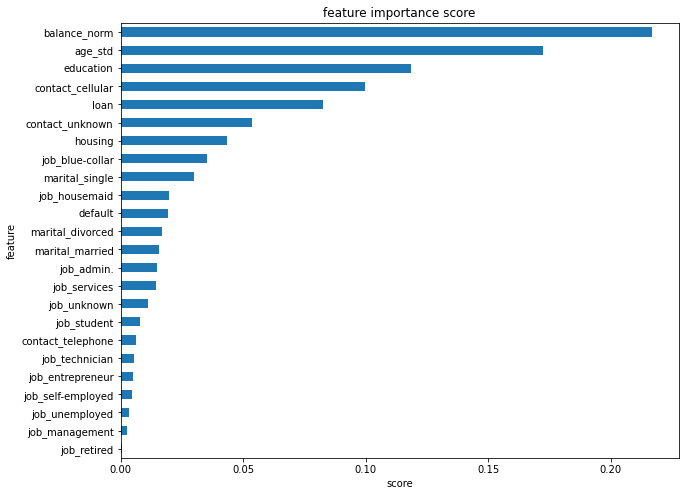

In [46]:
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

### Insights & Recommendations

Insights:
- Jumlah saldo, usia, dan pendidikan merupakan tiga fitur yang memiliki kekuatan prediktif mencapai 50%. Sisa 50%-nya terbagi ke 21 fitur lainnya.
- Pensiunan atau tidak, tidak memengaruhi pengambilan deposito baru.
- Pekerja kerah biru, ART, administrasi, dan sektor jasa memiliki jauh lebih besar kemungkinan mengambil deposito baru dibanding jenis pekerja lainnya.
- Orang yang belum pernah menikah lebih potensial dibanding yang sudah menikah atau cerai.
- Pemilik telepon seluler jauh lebih potensial dibanding yang tidak.
- Kepemilikan pembiayaan, seperti kredit rumah dan lainnya cukup memengaruhi keputusan pengambilan deposito baru.

Recommendations:
- Mendapatkan info jumlah saldo, usia, dan pendidikan harus menjadi prioritas.
- Pusatkan calling experience pada telepon seluler.
- Kemas produk deposito yang lebih menarik bagi pekerja lapangan.
- Pahami kebutuhan finansial orang-orang yang masih lajang karena merupakan pangsa pasar yang berpotensi lebih besar untuk berkembang dibanding yang sudah berkeluarga.

## Random Forest

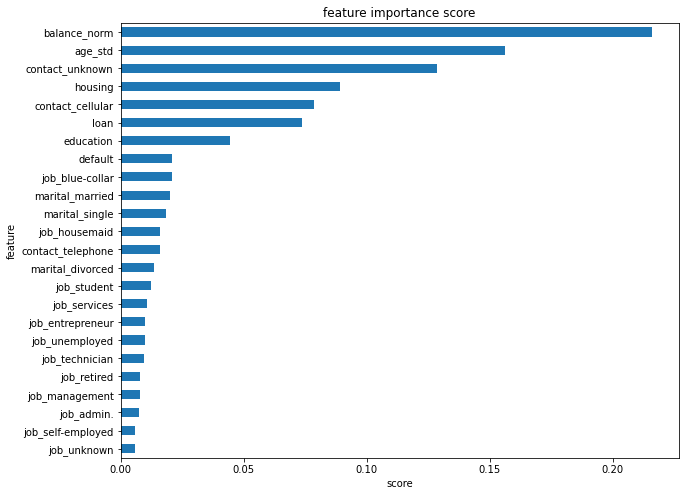

In [49]:
show_feature_importance(rf_tuned.best_estimator_)